The [SPAM](https://www.kaggle.com/uciml/sms-spam-collection-dataset) dataset contains 5572 SMS messages and a label. Using this dataset, you are going to create a machine learning model that learns to detect "spam" or not "spam".

## Imports Libraries

In [6]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import pickle
import tensorflow as tf
import wordcloud

# SIMPLE EDA

In [7]:
df = pd.read_csv("spam.csv",encoding='latin-1')
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


The Columns 2,3,4 will be dropped as they contain no relevant information

In [8]:
data = df.copy()
data.drop(columns=["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], inplace=True)
data = data.rename(columns={"v1":"label", "v2":"text"})

In [9]:
data.head()

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


### Distribution of the label variable

The dataset contains 4825 ham and 747 spam messages.  

In [10]:
data.label.value_counts()

ham     4825
spam     747
Name: label, dtype: int64

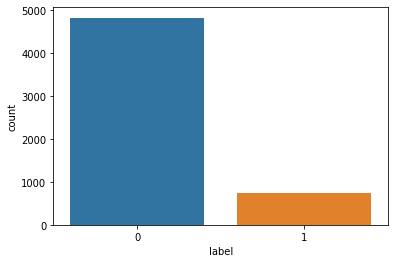

In [39]:
sns.countplot(data['label'])
plt.savefig("dist")
plt.show()


Convert labels numerical format

In [12]:
data['label'] = data['label'].map( {'spam': 1, 'ham': 0} )
data.head()

,label,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [18]:
data_ham  = data[data['label'] == 0].copy()
data_spam = data[data['label'] == 1].copy()

WordClouds

In [40]:
def show_wordcloud(df, title):
    text = ' '.join(df['text'].astype(str).tolist())
    stopwords = set(wordcloud.STOPWORDS)
    
    fig_wordcloud = wordcloud.WordCloud(stopwords=stopwords,background_color='lightgrey',
                    colormap='viridis', width=800, height=600).generate(text)
    
    plt.figure(figsize=(10,7), frameon=True)
    plt.imshow(fig_wordcloud)  
    plt.axis('off')
    plt.title(title, fontsize=20 )
    plt.savefig("wd.png")
    plt.show()

### WordCloud: Ham messages

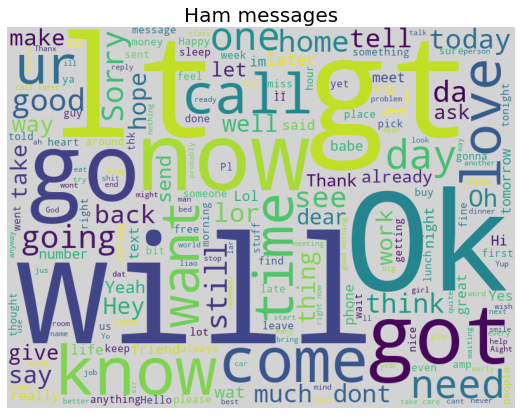

In [42]:
show_wordcloud(data_ham, "Ham messages")

### WordCloud: Spam messages

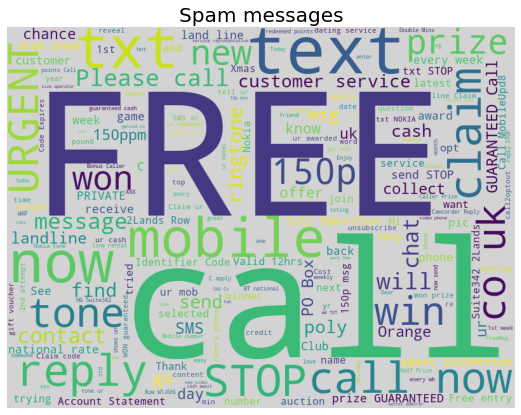

In [41]:
show_wordcloud(data_spam, "Spam messages")

Notice that majority of the word in Spam messages contains terms like FREE, CALL, URGENT. These terms will serve as important features to our model. 

In [22]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Embedding
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

X = data['text'].values
y = data['label'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

## FEATURE ENGINEERING AND PROCESSING

In [23]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Embedding
from tensorflow.keras.callbacks import EarlyStopping

In [69]:
# prepare tokenizer
t = Tokenizer()
t.fit_on_texts(X_train)

# integer encode the documents
encoded_train = t.texts_to_sequences(X_train)
encoded_test = t.texts_to_sequences(X_test)

vocab_size = len(t.word_index) + 1

print(encoded_train[0:2])

[[38, 30, 8, 5, 273, 1989, 81, 116, 26, 11, 1656, 322, 10, 53, 18, 299, 30, 349, 1990], [799, 15, 2555, 1442, 1127, 192, 2556, 171, 12, 98, 1991, 44, 195, 1657, 2557, 1992, 2558, 21, 9, 4, 203, 1025, 225]]


In [70]:
# pad documents to a max length of 4 words
max_length = 8
padded_train = pad_sequences(encoded_train, maxlen=max_length, padding='post')
padded_test = pad_sequences(encoded_test, maxlen=max_length, padding='post')

print(padded_train)

[[ 322   10   53 ...   30  349 1990]
 [1992 2558   21 ...  203 1025  225]
 [  83 1443    4 ...    2 3794 3795]
 ...
 [1477   30 2063 ...  239   30 2064]
 [ 763 1679 1161 ...    0    0    0]
 [   8  155   20 ...    8  290  175]]


In [71]:
# define the model
model = Sequential()
model.add(Embedding(vocab_size, 24, input_length=max_length))
model.add(Flatten())
model.add(Dense(500, activation='relu'))
model.add(Dense(200, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# compile the model
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

# summarize the model
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 8, 24)             190920    
_________________________________________________________________
flatten_3 (Flatten)          (None, 192)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 500)               96500     
_________________________________________________________________
dense_13 (Dense)             (None, 200)               100200    
_________________________________________________________________
dropout_3 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 100)               20100     
_________________________________________________________________
dense_15 (Dense)             (None, 1)                

In [72]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

# fit the model
model.fit(x=padded_train, 
          y=y_train, 
          epochs=50,
          validation_data=(padded_test, y_test), verbose=1,
          callbacks=[early_stop]
          )

Epoch 1/50
140/140 [==============================] - 0s 3ms/step - loss: 0.1902 - accuracy: 0.9278 - val_loss: 0.0998 - val_accuracy: 0.9758
Epoch 2/50
140/140 [==============================] - 0s 2ms/step - loss: 0.0486 - accuracy: 0.9838 - val_loss: 0.0709 - val_accuracy: 0.9830
Epoch 3/50
140/140 [==============================] - 0s 2ms/step - loss: 0.0175 - accuracy: 0.9957 - val_loss: 0.0947 - val_accuracy: 0.9821
Epoch 4/50
140/140 [==============================] - 0s 3ms/step - loss: 0.0047 - accuracy: 0.9989 - val_loss: 0.1229 - val_accuracy: 0.9821
Epoch 5/50
140/140 [==============================] - 0s 3ms/step - loss: 7.6717e-05 - accuracy: 1.0000 - val_loss: 0.2457 - val_accuracy: 0.9785
Epoch 6/50
140/140 [==============================] - 0s 3ms/step - loss: 2.0623e-06 - accuracy: 1.0000 - val_loss: 0.3220 - val_accuracy: 0.9758
Epoch 7/50
140/140 [==============================] - 0s 3ms/step - loss: 2.6336e-08 - accuracy: 1.0000 - val_loss: 0.2659 - val_accuracy: 0

In [73]:
# evaluate the model
loss, accuracy = model.evaluate(padded_test, y_test, verbose=0)
print('Accuracy: %f' % (accuracy*100))

Accuracy: 98.206276


In [74]:
preds = (model.predict(padded_test) > 0.5).astype("int32")

In [80]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


def c_report(y_true, y_pred):
    print("Classification Report")
    print(classification_report(y_true, y_pred))
    acc_sc = accuracy_score(y_true, y_pred)
    print("Accuracy : "+ str(acc_sc))
    return acc_sc


def plot_confusion_matrix(y_true, y_pred):
    mtx = confusion_matrix(y_true, y_pred)
    sns.heatmap(mtx, annot=True, fmt='d', linewidths=.5,  
                cmap="Blues", cbar=False)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig("cf.png")

In [81]:
c_report(y_test, preds)

Classification Report
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       965
           1       0.99      0.87      0.93       150

    accuracy                           0.98      1115
   macro avg       0.99      0.94      0.96      1115
weighted avg       0.98      0.98      0.98      1115

Accuracy : 0.9820627802690582


0.9820627802690582

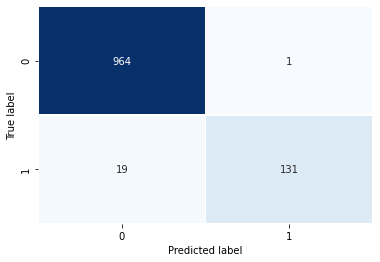

In [82]:
plot_confusion_matrix(y_test, preds)

## SAVING MODEL AND TOKENIZER

In [78]:
model.save("spam_model")

INFO:tensorflow:Assets written to: spam_model/assets


In [79]:
with open('spam_model/tokenizer.pkl', 'wb') as output:
    pickle.dump(t, output, pickle.HIGHEST_PROTOCOL)

## LOADING AND EVALUATING MODEL

In [39]:
s_model = tf.keras.models.load_model("spam_model")

with open('spam_model/tokenizer.pkl', 'rb') as input:
    tokener = pickle.load(input)
 
s_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 15, 16)            127280    
_________________________________________________________________
flatten (Flatten)            (None, 240)               0         
_________________________________________________________________
dense (Dense)                (None, 500)               120500    
_________________________________________________________________
dense_1 (Dense)              (None, 200)               100200    
_________________________________________________________________
dense_2 (Dense)              (None, 100)               20100     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 101       
Total params: 368,181
Trainable params: 368,181
Non-trainable params: 0
__________________________________________________

In [40]:
sms = [X_test[2]]
print(sms)
print(y_test[1], y_test[2])

sms_proc = tokener.texts_to_sequences(sms)
sms_proc = pad_sequences(sms_proc, maxlen=max_length, padding='post')

['We know someone who you know that fancies you. Call 09058097218 to find out who. POBox 6, LS15HB 150p']
0 1


In [44]:
pred = (model.predict(sms_proc) > 0.5).astype("int32").item()
pred

1